In [1]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd

from torch.utils.data import DataLoader
from torch.nn.functional import binary_cross_entropy
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torch.nn import Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Module
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import math
from torchvision import models
import warnings
warnings.filterwarnings("ignore")

In [6]:
pre_dir = 'D:/Project/data_crop/'

In [20]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
import cv2
import torchvision.transforms.functional as tx
from sklearn.utils import shuffle
import torch
class AL_Dataset():
    def __init__(self, mode):
        if(mode=="train"):
            self.AD_dir = np.array(os.listdir(pre_dir+"training_data/AD"))
            self.CN_dir = np.array(os.listdir(pre_dir+"training_data/CN"))
        else:
            self.AD_dir = np.array(os.listdir(pre_dir+"validation_data/AD"))
            self.CN_dir = np.array(os.listdir(pre_dir+"validation_data/CN"))
        self.AD = np.ones((len(self.AD_dir)))
        self.CN = np.zeros((len(self.CN_dir)))
        self.df = np.concatenate((self.AD_dir, self.CN_dir))
        self.label = np.concatenate((self.AD, self.CN))
        self.df, self.label = shuffle(self.df, self.label)
        self.mode = mode
        self.label_df = pd.read_csv("../data/B1_correction_new.csv")

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        if self.mode=="train":
            if self.label[idx]==1:
                image_path = pre_dir+"training_data/AD/"+self.df[idx]
                label_Al = 1
            else:
                image_path = pre_dir+"training_data/CN/"+self.df[idx]
                label_Al = 0
        else:
            if self.label[idx]==1:
                image_path = pre_dir+"validation_data/AD/"+self.df[idx]
                label_Al = 1
            else:
                image_path = pre_dir+"validation_data/CN/"+self.df[idx]
                label_Al = 0
        patient_ID = image_path.split("/")[5].split(".")[0]
        index = list(self.label_df["Image Data ID"]).index(patient_ID)
        sex = self.label_df["Sex"][index]
        if sex =="M":
          label_sex = 1
        else:
          label_sex = 0

        whole_image = nib.load(image_path)
        whole_image = np.array(whole_image.dataobj)
        image_arr = np.zeros((90, 256, 256, 3))
        for i in range((90)):            
            image = whole_image[i]
            image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)
            image = normalize(image)
            image = image.reshape(256, 256, 1)
            image = np.concatenate((image, image, image), 2)
            image_arr[i] = image
        return image_arr, label_Al, label_sex
    
def normalize(arr):
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    return (arr - arr_min) / (arr_max - arr_min)

In [21]:
train_dataset = AL_Dataset("train")
val_dataset = AL_Dataset("valid")
train_dataloader = DataLoader(train_dataset, batch_size = 1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size = 1, shuffle = True)


In [22]:
# model_arr = []
# level_index = []
# model_sex_arr=[]
# level_sex_index=[]
# for i in range(30,60):
#     if os.path.exists("drive/MyDrive/Alzheimer/data/models/level_"+str(i)+"_best.pth"):
#         print("find : ", i)
#         model = models.resnet34(pretrained=True)
#         model.fc = nn.Linear(512, 2)
#         model.load_state_dict(torch.load("drive/MyDrive/Alzheimer/data/models/level_"+str(i)+"_best.pth"))
#         model_arr.append(model)
#         level_index.append(i)
#     if os.path.exists("drive/MyDrive/Alzheimer/data/models_sex/level_"+str(i)+"_best.pth"):
#         print("find : ", i)
#         model = models.resnet34(pretrained=True)
#         model.fc = nn.Linear(512, 2)
#         model.load_state_dict(torch.load("drive/MyDrive/Alzheimer/data/models_sex/level_"+str(i)+"_best.pth"))
#         model_sex_arr.append(model)
#         level_sex_index.append(i)
# #     else:
# #         model_arr.append(None)

In [23]:

# image, label = next(iter(train_dataloader))
# print(label)

In [24]:
def get_saliency_Al(model, infer_image, label):
  infer_image = infer_image.float()
  infer_image.requires_grad_()
  score = model(infer_image)
  score_max_index = score.argmax()
  score_max = score[0,score_max_index]
  score_max.backward()
  if score_max_index == label:
      correctness = (1)
  else:
      correctness = (0)
  saliency = infer_image.grad.data.abs()
  saliency, _ = torch.max(saliency, dim=1)
  return saliency[0], correctness

In [25]:
def get_saliency_sex(model, infer_image, label):
  infer_image = infer_image.float()
  infer_image.requires_grad_()
  score = model(infer_image)
  score_max_index = score.argmax()
  score_max = score[0,score_max_index]
  score_max.backward()
  if score_max_index == label:
      correctness = (1)
  else:
      correctness = (0)
  saliency = infer_image.grad.data.abs()
  saliency, _ = torch.max(saliency, dim=1)
  return saliency[0], correctness

In [26]:
def get_ratio(saliency_Al, saliency_sex):
  ratio = torch.zeros((256, 256))
  for i in range(saliency_Al.shape[0]):
    for j in range(saliency_Al.shape[1]):
      if saliency_Al[i][j]==0 and saliency_sex[i][j]==0:
        ratio[i][j]=0
      if saliency_Al[i][j]>=saliency_sex[i][j]:
        ratio[i][j] = saliency_sex[i][j]/saliency_Al[i][j]
      else:
        ratio[i][j] = saliency_Al[i][j]/saliency_sex[i][j]
  return ratio


In [27]:
def get_absolute_intersection(saliency_Al, saliency_sex, threshold):
  intersection = torch.zeros((256, 256))
  if threshold==0.5:
    Al = saliency_Al>torch.mean(saliency_Al)
    sex = saliency_sex>torch.mean(saliency_sex)
  elif threshold==0.75:
    Al = saliency_Al>(torch.mean(saliency_Al)*4/3)
    sex = saliency_sex>(torch.mean(saliency_sex)*4/3)
  for i in range(saliency_Al.shape[0]):
    for j in range(saliency_Al.shape[1]):
      if Al[i][j]>0 and sex[i][j]>0:
        intersection[i][j] = 1
  return intersection

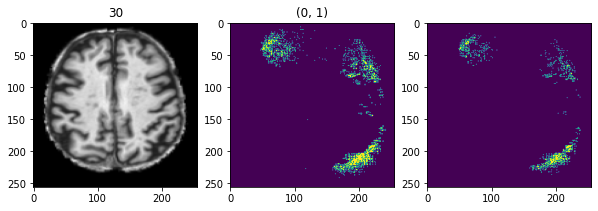

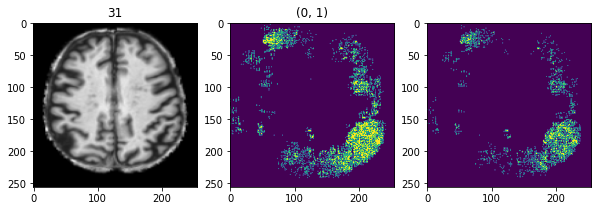

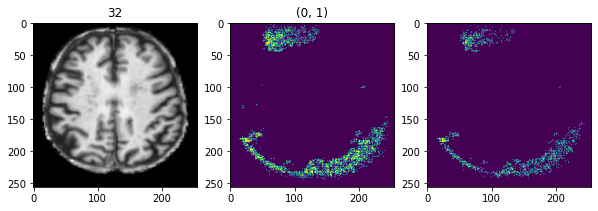

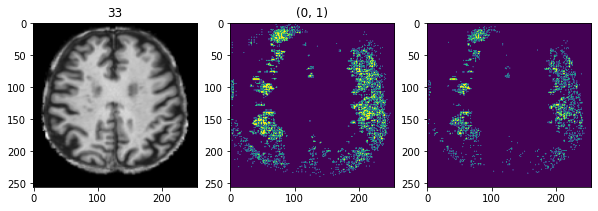

KeyboardInterrupt: 

In [28]:
image, label_Al, label_sex = next(iter(val_dataloader))
# image_arr=[]
# intersection_arr=[]
# correctness_arr=[]
for i in range(30,60):
        # print(i)
        # infer_image = image[:,level_index[i]]
        infer_image = image[:,i]
        infer_image = torch.moveaxis(infer_image,3,1)

        model = models.resnet34(pretrained=True)
        model.fc = nn.Linear(512, 2)
        model.load_state_dict(torch.load("../data/models/level_"+str(i)+"_best.pth"))
        saliency_Al, correctness_Al = get_saliency_Al(model, infer_image, label_Al)

        model = models.resnet34(pretrained=True)
        model.fc = nn.Linear(512, 2)
        model.load_state_dict(torch.load("../data/models_sex/level_"+str(i)+"_best.pth"))
        saliency_sex, correctness_sex = get_saliency_sex(model, infer_image, label_sex)

        ratio = get_ratio(saliency_Al, saliency_sex)
        intersection_50 = get_absolute_intersection(saliency_Al, saliency_sex, 0.5)
        intersection_75 = get_absolute_intersection(saliency_Al, saliency_sex, 0.75)

        inputs = infer_image[0].detach().cpu()
        inputs = torch.moveaxis(inputs,0,2)

        # correctness_arr.append((correctness_Al, correctness_sex))
        # image_arr.append(inputs)
        # intersection_arr.append(intersection)

        f, axs = plt.subplots(2,2,figsize=(10,10))
        plt.subplot(1,3,1)
        plt.title((i))
        plt.imshow(inputs)
        plt.subplot(1,3,2)
        plt.title((correctness_Al, correctness_sex))
        plt.imshow(intersection_50)
        plt.subplot(1,3,3)
        plt.imshow(intersection_75)
        plt.show()
        f.clear()
        plt.close(f)
        # plt.subplot(2,2,1)
        # plt.imshow(inputs)
        # plt.subplot(2,2,2)
        # plt.imshow(saliency_Al)
        # plt.subplot(2,2,3)
        # plt.imshow(saliency_sex)
        # plt.subplot(2,2,4)
        # plt.imshow(intersection)
        # break


In [ ]:
# # f, axs = plt.subplots(2,2,figsize=(30,30))
# for i in range(len(image_arr)):
#   f, axs = plt.subplots(2,2,figsize=(10,10))
#   # plt.title((i))
#   plt.subplot(1,2,1)
#   plt.title((i))
#   plt.imshow(image_arr[i])
#   plt.subplot(1,2,2)
#   plt.title((correctness_arr[i]))
#   plt.imshow(intersection_arr[i])
#   plt.show()
#   f.clear()
#   plt.close(f)

In [ ]:
# for j in range(1):
#     image_arr=[]
#     saliency_arr=[]
#     # image, label = next(iter(val_dataloader))
# #     print(label)
#     correctness=[]
#     for i in range(len(model_arr)):

#         print(i)


#         infer_image = image[:,level_index[i]]
#         infer_image = torch.moveaxis(infer_image,3,1)
#         model = model_arr[i]
#         infer_image = infer_image.float()
#         infer_image.requires_grad_()

#         score = model(infer_image)
#         sig = nn.Sigmoid()

#         score_max_index = score.argmax()
#         if score_max_index == label:
#             correctness.append(1)
#         else:
#             correctness.append(0)

#         score_max = score[0,score_max_index]
#         score_max.backward()

#         saliency = infer_image.grad.data.abs()
#         saliency, _ = torch.max(saliency, dim=1)


#         inputs = infer_image[0].detach().cpu()

#         inputs = torch.moveaxis(inputs,0,2)

#         image_arr.append(inputs)
#         saliency_arr.append(saliency[0])


In [ ]:
# for j in range(1):
#     image_sex_arr=[]
#     saliency_sex_arr=[]
#     image, label = next(iter(val_dataloader))
# #     print(label)
#     correctness=[]
#     for i in range(len(model_sex_arr)):

#         print(i)
# #         print(level_index[i])

#         infer_image = image[:,level_sex_index[i]]
#         infer_image = torch.moveaxis(infer_image,3,1)
#         model = model_sex_arr[i]
#         infer_image = infer_image.float()
#         infer_image.requires_grad_()
#     #     print(infer_image)
#         score = model(infer_image)
#         sig = nn.Sigmoid()
#         # print(sig(score))
#         score_max_index = score.argmax()
#         if score_max_index == label:
#             correctness.append(1)
#         else:
#             correctness.append(0)

#         score_max = score[0,score_max_index]
#         score_max.backward()

#         saliency = infer_image.grad.data.abs()
#         saliency, _ = torch.max(saliency, dim=1)


#         inputs = infer_image[0].detach().cpu()

#         inputs = torch.moveaxis(inputs,0,2)

#         image_sex_arr.append(inputs)
#         saliency_sex_arr.append(saliency[0])



In [ ]:
# print(len(saliency_sex_arr))

In [ ]:
# for j in range(7):
#     f, axs = plt.subplots(2,2,figsize=(30,30))
#     for i in range(15):
        
#         if i+j*15>=len(image_sex_arr):
#             break
#         plt.title((correctness[i+j*15],i+j*15))
#         plt.subplot(5,6,2*i+1)
#         plt.imshow(image_sex_arr[i+j*15])
# #         plt.subplot(5,6,3*i+2)
# #         plt.imshow(saliency_arr[i+j*15])
#         plt.subplot(5,6,2*i+2)
#         plt.imshow(saliency_sex_arr[i+j*15])
#     plt.show()

In [ ]:
# for j in range(7):
#     f, axs = plt.subplots(2,2,figsize=(30,30))
#     for i in range(15):
        
#         if i+j*15>=len(image_arr):
#             break
#         plt.title((correctness[i+j*15],i+j*15))
#         plt.subplot(5,6,2*i+1)
#         plt.imshow(image_arr[i+j*15])
# #         plt.subplot(5,6,3*i+2)
# #         plt.imshow(saliency_arr[i+j*15])
#         plt.subplot(5,6,2*i+2)
#         plt.imshow(saliency_arr[i+j*15])
#     plt.show()